# Aplicación de SentenceTransformers para detección de Tópicos

Objetivos:

* Aplicar el algoritmo modular de BERTopic en un dataset en comentarios realizados en una red social
* Diseñar un experimento que permita setear hiperparametros a nivel de UMAP
* Visualizar los resultados de cada uno de los modelos de SentnceTransformers
* 

# El Algoritmo BERTopic

En esta tarea, nos adentraremos en el área de **modelamiento de tópicos (topic modeling)**. Para ello, utilizaremos el algoritmo BERTopic, diseñado para descubrir tópicos de forma no-supervisada dentro de un corpus, clasificando  documentos en cada una de las categorías encontradas.
Se trata de un algoritmo con 5 etapas (más una 6ta etapa opcional), que se detalla en la figura.

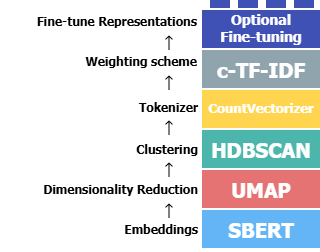

BERTopic utiliza el algoritmo CountVectorizer para tokenizar, así como una versión class-based de TF-IDF para crear las representaciones de tópicos.

El esquema del algoritmo es modular, permitiendo cambiar los modelos utilizados para las distintas etapas.
**En esta tarea, modificaremos únicamente la etapa de Embeddings,** encargada de transformar el texto en representaciones vectoriales.




# Instalar BERTopic

In [1]:
from bertopic import BERTopic

# Embeddings

La primera etapa del algoritmo consiste en obtener representaciones vectoriales del texto en los documentos, es decir calcular embeddings.

La modularidad del algoritmo BERTopic permite utilizar varios de los métodos:

- Flair para importar *transformers encoders*
-  Spacy
-  Gensim para *Word2Vec, FastText, Glove*
-  TF-IDF

In [2]:
# Ejemplo con sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

Para el desarrollo de la tarea le puede ser de utilidad guardar los modelos de tópicos que ha ajustado. Revise esta sección de la [documentación](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#saveload-bertopic-model\)

In [3]:
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer

umap_model = UMAP(random_state=42)

vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))



---


# Load Dataset 

El dataset para esta tarea es TweetTopic versión multi label. Se trata de un compilado de tweets clasificados en 19 tópicos, cuyos textos se encuentran preprocesados para reemplazar tags de usuarios y URLs. Para más información revise este [link](https://huggingface.co/datasets/cardiffnlp/tweet_topic_multi)

In [53]:
label2id = {
    "arts_&_culture": 0,
    "business_&_entrepreneurs": 1,
    "celebrities_&_pop_culture": 2,
    "diaries_&_daily_life": 3,
    "family": 4,
    "fashion_&_style": 5,
    "film_tv_&_video": 6,
    "fitness_&_health": 7,
    "food_&_dining": 8,
    "gaming": 9,
    "learning_&_educational": 10,
    "music": 11,
    "news_&_social_concern":12,
    "other_hobbies": 13,
    "relationships": 14,
    "science_&_technology": 15,
    "sports": 16,
    "travel_&_adventure": 17,
    "youth_&_student_life": 18
}

Instrucción: Cargue el dataset desde el archivo train.csv usando la librería pandas. Luego visualice la distribución por clase.

# Parte 0 : Exploración del dataset

- El objetivo de esta sección es ver la representación temática de acuerdo a los labels presentados en diccionario de la sección anterior.


In [5]:
### Importe de depencencias para la pregunta 

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

### Setup de estilos para gráficos:
plt.style.use('ggplot')

## Warnings
import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv('train.csv')
df.head()

text        date  \
0  The {@Clinton LumberKings@} beat the {@Cedar R...  2019-09-08   
1  I would rather hear Eli Gold announce this Aub...  2019-09-08   
2  Someone take my phone away, I’m trying to not ...  2019-09-08   
3  A year ago, Louisville struggled to beat an FC...  2019-09-08   
4  Anyone know why the #Dodgers #Orioles game nex...  2019-09-08   

                                               label  label_name  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ['sports']   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ['sports']   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ['sports']   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ['sports']   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ['sports']   

                    id  
0  1170516324419866624  
1  1170516440690176006  
2  1170516543387709440  
3  1170516620466429953  
4  1170516711411310592

In [7]:
### Tipos de datos en el dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6090 entries, 0 to 6089
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        6090 non-null   object
 1   date        6090 non-null   object
 2   label       6090 non-null   object
 3   label_name  6090 non-null   object
 4   id          6090 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 238.0+ KB


In [ ]:
## Se observa que los elementos del label son string, por lo cual se procede a transformarlos a una lista para iterar sobre los valores de cada clase.
df['label'][0]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]'

In [9]:
### Transformación de sting a lista:
df['label_list'] = df['label'].apply(lambda x: ast.literal_eval(x))

#### Generación de dataframe para conteo de clases:
df_aux = pd.DataFrame(df["label_list"].to_list())

#### Remapeo de nombre de columnas a id de clases de dict label2id:

id2label_rev = {
    0:'arts_&_culture', 1:'business_&_entrepreneurs', 2:'celebrities_&_pop_culture',
    3:'diaries_&_daily_life', 4:'family', 5:'fashion_&_style', 6:'film_tv_&_video',
    7:'fitness_&_health', 8:'food_&_dining', 9:'gaming', 10:'learning_&_educational',
    11:'music', 12:'news_&_social_concern', 13:'other_hobbies', 14:'relationships',
    15:'science_&_technology', 16:'sports', 17:'travel_&_adventure', 18:'youth_&_student_life'
}

df_aux = df_aux.rename(columns=id2label_rev)
df_aux.head()


arts_&_culture  business_&_entrepreneurs  celebrities_&_pop_culture  \
0               0                         0                          0   
1               0                         0                          0   
2               0                         0                          0   
3               0                         0                          0   
4               0                         0                          0   

   diaries_&_daily_life  family  fashion_&_style  film_tv_&_video  \
0                     0       0                0                0   
1                     0       0                0                0   
2                     0       0                0                0   
3                     0       0                0                0   
4                     0       0                0                0   

   fitness_&_health  food_&_dining  gaming  learning_&_educational  music  \
0                 0              0       0                       0      0   
1                 0              0       0                       0      0   
2                 0              0       0                       0      0   
3                 0              0       0                       0      0   
4                 0              0       0                       0      0   

   news_&_social_concern  other_hobbies  relationships  science_&_technology  \
0                      0              0              0                     0   
1                      0              0              0                     0   
2                      0              0              0                     0   
3                      0              0              0                     0   
4                      0              0              0                     0   

   sports  travel_&_adventure  youth_&_student_life  
0       1                   0                     0  
1       1                   0                     0  
2       1                   0                     0  
3       1                   0                     0  
4       1                   0                     0

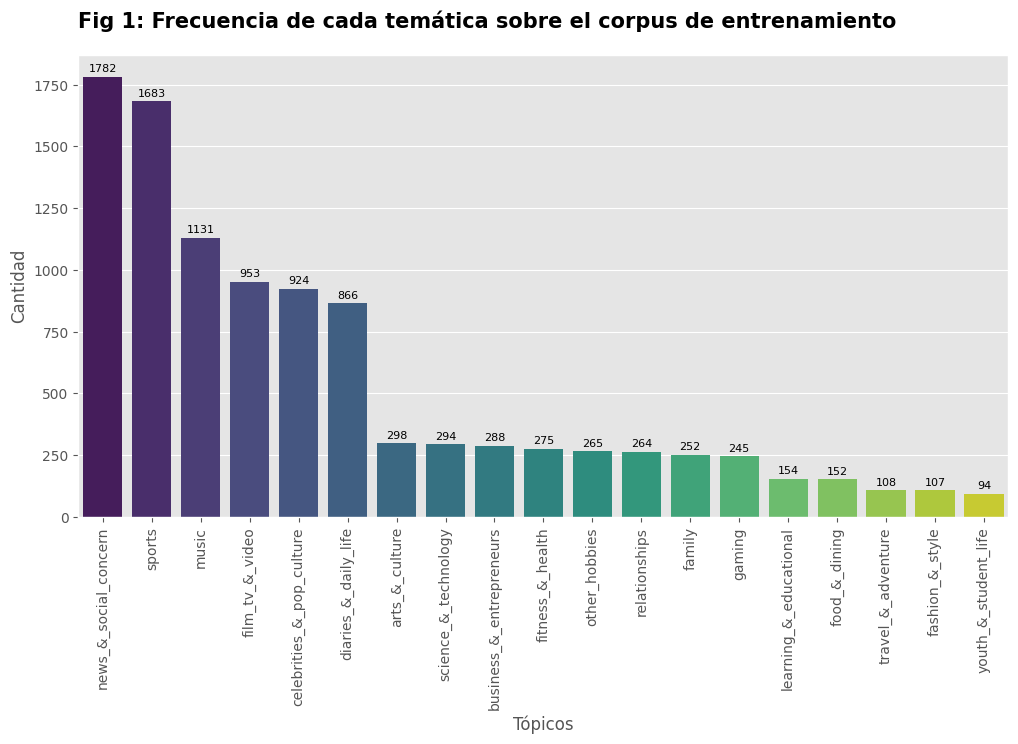

In [10]:
### Calculo de cantidad de elementos por clase:
counts = df_aux.sum().sort_values(ascending=False)
counts

### Visualización de cantidad de elementos por clase:
plt.figure(figsize=(12,6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
plt.xlabel('Tópicos')
plt.title('Fig 1: Frecuencia de cada temática sobre el corpus de entrenamiento', fontsize=15, pad=20, weight='bold', loc='left')

### Agregar etiquetas de cantidad sobre las barras
for i, v in enumerate(counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontsize=8)

plt.show();

**Observaciones**
---
* Existen comentarios que tienen más de una temática, por lo cual al momento de realizar un estudio de caracterización de tópicos los clusters podrían colisionar.

* Naturalmente, la visualización se construye mediante el vector de labels, en donde se observa predominancia sobre de temas de interés general además de deporte y música. Así mismos, existen otros tópicos más específicos que están sub-representados, dentro de los cuales se destacan `'moda y estilo de vida'`, `'Viajes y Aventuras'` (ver tópicos la lado derecho de la figura 1).

# Parte 1 : Implementación modelos de `Embeddings`

**Experimentación**
---

Dado que la tarea busca comprar el desempeño de los embeddings en relación al modelo de `SentenceTransformer`se decide buscar los mejores hiper-parámetros para `CountVectorizer` así como para el `UMPA`. Para estos fines se generan 4 posibles combinaciones de estos parámetros.

* Es relevante mencionar para el tamaño del corpus, ~6000 registros, se acotarán algunos valores, por ejemplo `min_df` se probará valores de 2 a 3. Así mismo, `n_neighbors` se probarán 3 tipos de valores (bajos, balanceado y altos), esperando resultados más granurales a más generales.

* Para evaluar los mejores hiper-parametros se utilizarán metricas globales las cuales son:

    * $outlier_{ratio}$ : Mide el % de observaciones que no son clasificadas en algún tipo de tópico.

    * $Topic_{diversity}$ : Mide la diversidad temática de los tópicos detectados, en base a top 10 palabras de todos los tópicos.

        * Este ratio suele ser bastante útil, ya que permite alertar que la diversidad sea baja, la generalización de los tópicos no es la más adecuada, ya que, se generan temáticas repetidas debido a que las palabras de soporte de las clases pueden ser muy genéricas.

In [11]:
### Implementación del experimento anteriormente descrito:

def num_topics(model):
    '''
    Cuenta el número de tópicos distintos en el modelo, excluyendo el tópico -1 (outliers).
        input: modelo BERTopic
        output: int (número de tópicos)
    '''
    return sum(1 for k in model.get_topics().keys() if k != -1) 

def outlier_ratio(topics):
    '''
    Calcula el ratio de outliers en los tópicos asignados.
        input: lista de tópicos asignados a cada documento
        output: float (ratio de outliers)
    '''
    a = np.array(topics)
    return (a == -1).sum() / len(a)

def topic_diversity(model, topk=10):
    '''
    Calcula la diversidad de tópicos en el modelo, de acuerdo a los 10 tópicos más representativos de los clústers detectados.
        input: modelo BERTopic, topk (número de palabras por tópico a considerar)
        output: float (diversidad de tópicos)
    '''
    vocab = []
    for tid, words in model.get_topics().items():
        if tid == -1: 
            continue
        vocab += [w for w, _ in words[:topk]]
    return len(set(vocab)) / max(1, len(vocab))

def evaluate_setup(name, umap_model, vectorizer_model, docs, embedding_model):
    tm = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        vectorizer_model=vectorizer_model,
        language="english",
        verbose=True
    )
    topics, probs = tm.fit_transform(docs)
    report = {
        "setup": name,
        "topics": num_topics(tm),
        "outliers_%": round(outlier_ratio(topics)*100, 2),
        "diversity@10": round(topic_diversity(tm, 10), 3)
    }
    return tm, topics, report

### Modelo de embedding:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

### Vectorizers
vec_bal  = CountVectorizer(stop_words='english', min_df=2, max_df=0.9, ngram_range=(1,2), max_features=10000)
vec_gran = CountVectorizer(stop_words='english', min_df=2, max_df=0.3, ngram_range=(1,3), max_features=15000)
vec_rob  = CountVectorizer(stop_words='english', min_df=3, max_df=0.4, ngram_range=(1,2), max_features=7000)

### UMAP
umap_bal  = UMAP(n_neighbors=15, min_dist=0.2, n_components=5, metric='cosine', random_state=42)
umap_gran = UMAP(n_neighbors=8,  min_dist=0.0, n_components=5, metric='cosine', random_state=42)
umap_lo   = UMAP(n_neighbors=30, min_dist=0.3, n_components=5, metric='cosine', random_state=42)

combinaciones = [
    ("bal+bal",  umap_bal,  vec_bal),
    ("gran+gran",umap_gran, vec_gran),
    ("lo+rob",   umap_lo,   vec_rob),
    ("bal+rob",  umap_bal,  vec_rob),
]

docs = df['text'].tolist()
models = []
reports = []
for name, u, v in combinaciones:
    tm, t, rep = evaluate_setup(name, u, v, docs, embedding_model)
    models.append((name, tm, t))
    reports.append(rep)

for r in reports:
    print(r)


2025-08-31 18:38:57,574 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 18:39:03,862 - BERTopic - Embedding - Completed ✓
2025-08-31 18:39:03,862 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 18:39:13,082 - BERTopic - Dimensionality - Completed ✓
2025-08-31 18:39:13,082 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 18:39:13,172 - BERTopic - Cluster - Completed ✓
2025-08-31 18:39:13,173 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 18:39:13,311 - BERTopic - Representation - Completed ✓
2025-08-31 18:39:13,377 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 18:39:18,853 - BERTopic - Embedding - Completed ✓
2025-08-31 18:39:18,854 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 18:39:22,689 - BERTopic - Dimensionality - Completed ✓
2025-08-31 18:39:22,689 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 18:39:22,764 - BERTopic - Cluster - Completed ✓
2025-08-31 18:39:22,765 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 18:39:23,055 - BERTopic - Representation - Completed ✓
2025-08-31 18:39:23,164 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 18:39:28,520 - BERTopic - Embedding - Completed ✓
2025-08-31 18:39:28,520 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 18:39:35,307 - BERTopic - Dimensionality - Completed ✓
2025-08-31 18:39:35,308 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 18:39:35,408 - BERTopic - Cluster - Completed ✓
2025-08-31 18:39:35,409 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 18:39:35,551 - BERTopic - Representation - Completed ✓
2025-08-31 18:39:35,609 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 18:39:41,436 - BERTopic - Embedding - Completed ✓
2025-08-31 18:39:41,437 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 18:39:46,416 - BERTopic - Dimensionality - Completed ✓
2025-08-31 18:39:46,417 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 18:39:46,513 - BERTopic - Cluster - Completed ✓
2025-08-31 18:39:46,514 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 18:39:46,667 - BERTopic - Representation - Completed ✓


{'setup': 'bal+bal', 'topics': 68, 'outliers_%': np.float64(48.16), 'diversity@10': 0.907}
{'setup': 'gran+gran', 'topics': 115, 'outliers_%': np.float64(34.17), 'diversity@10': 0.909}
{'setup': 'lo+rob', 'topics': 56, 'outliers_%': np.float64(54.42), 'diversity@10': 0.912}
{'setup': 'bal+rob', 'topics': 68, 'outliers_%': np.float64(48.16), 'diversity@10': 0.872}


### Conclusiones Experimento

* La mejor configuración es la `{'setup': 'bal+bal', 'topics': 68, 'outliers_%': np.float64(48.16), 'diversity@10': 0.924}` .

* En General se observa que términos de diversidad las 4 configuraciones consiguen valores similares, por lo tanto, se debe realizar un trade off entre la cantidad de tópicos y los outliers. En este caso, vemos que la configuración `gran + gran` conduce a minimizar los outliers aumentando de manera considerable los tópicos, casi al doble por 14%.

* La configuración balanceada generaliza de mejor manera, y conduce a no tener tópicos muy específicos ("raros"). Ahora bien, es esperable que el algoritmo agrupe por tipo de deporte, por ejemplo, fútbol americano (NFL), Fútbol (Premier League), Artes Marciales Mixtas (MMA), Básquetbol (NBA) entre otros. Sin embargo, posteriormente estos se pueden re-agrupar que son parte de deporte. 

* En base a lo anterior, incorporar grupos más raros hará que una generalización global sea más compleja.

In [12]:
#### Configuración final de los modelos:

### Selección del mejor modelo:
vectorizer_model = CountVectorizer(stop_words='english', min_df=2, max_df=0.9, ngram_range=(1,2), max_features=10000)

# UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.2, n_components=5, metric='cosine', random_state=42)

## Topic Model #0: SBERT

In [13]:
### Aplicación de Bertopic con uso SentenceTransformer

topic_model_0 = BERTopic(embedding_model=embedding_model
                       ,umap_model=umap_model
                       ,vectorizer_model=vectorizer_model
                       ,language="english"
                       ,verbose=True
                       )

docs = df['text'].tolist()
topics_0, probs_0 = topic_model_0.fit_transform(docs)
topic_model_0.get_topic_info()

2025-08-31 18:39:46,762 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 18:39:52,105 - BERTopic - Embedding - Completed ✓
2025-08-31 18:39:52,105 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 18:39:57,108 - BERTopic - Dimensionality - Completed ✓
2025-08-31 18:39:57,109 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 18:39:57,220 - BERTopic - Cluster - Completed ✓
2025-08-31 18:39:57,221 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 18:39:57,371 - BERTopic - Representation - Completed ✓


Topic  Count                                               Name  \
0      -1   2933                 -1_username username_new_love_time   
1       0    226                          0_chiefs_nfl_49ers_browns   
2       1    212                        1_league_fc_manchester_city   
3       2    183            2_music video_video_youtube_url youtube   
4       3    167                       3_trump_president_news_biden   
..    ...    ...                                                ...   
64     63     11                   63_rolling loud_loud_rolling_mad   
65     64     11           64_drinking_patrick_untappd home_untappd   
66     65     11  65_aaron hernandez_hernandez_hernandez documen...   
67     66     10             66_harry_harry styles_styles_direction   
68     67     10   67_olivia_license_drivers license_olivia rodrigo   

                                       Representation  \
0   [username username, new, love, time, just, yea...   
1   [chiefs, nfl, 49ers, browns, super bowl, bowl,...   
2   [league, fc, manchester, city, premier league,...   
3   [music video, video, youtube, url youtube, mus...   
4   [trump, president, news, biden, president trum...   
..                                                ...   
64  [rolling loud, loud, rolling, mad, travis scot...   
65  [drinking, patrick, untappd home, untappd, val...   
66  [aaron hernandez, hernandez, hernandez documen...   
67  [harry, harry styles, styles, direction, just ...   
68  [olivia, license, drivers license, olivia rodr...   

                                  Representative_Docs  
0   [I was never a Bulls fan, but very much lookin...  
1   [Iconic play from Chiefs  Super Bowl LIV win c...  
2   [Chelsea in the FA Cup final, Chelsea womens i...  
3   [Mary J. Blige, U2 - One (Official Music Video...  
4   [Joe Biden almost drops F-BOMB during speech a...  
..                                                ...  
64  [ROLLING LOUD WAS LIT I CANT FEEL ANYTHING IN ...  
65  [ ask-peach-kisses: “HAPPY VALENTINE’S DAY!” -...  
66  [Netflix’s Aaron Hernandez Documentary Finally...  
67  [Harry Styles Says One Direction ‘Became Close...  
68  [Drivers license by {@Olivia Rodrigo@} is so g...  

[69 rows x 5 columns]

In [14]:
outlier_count_0 = np.sum(np.array(topics_0) == -1)
outlier_ratio_0 = outlier_count_0 / len(topics_0)

print(f"Outliers: {outlier_count_0} documentos ({outlier_ratio_0:.2%})")

Outliers: 2933 documentos (48.16%)


## Visualización de Resultados : Model 0 - sBert

In [31]:
#### Plot palabras
topic_model_0.visualize_barchart(top_n_topics=12, title="Fig 2: Palabras Representativas por tópico, modelo = 'sBert' ")

In [37]:
### Visualización de los tópicos en espacio 2D
topic_model_0.visualize_topics(title="Fig 3: Visualización de tópicos, modelo = 'sBert' ")

In [36]:
### HeadMAP
topic_model_0.visualize_heatmap(title="Fig 4: Heatmap de similitud entre tópicos, modelo = 'sBert' ")

In [59]:
topic_model_0.visualize_documents(docs=docs, title="Fig 5: Visualización de documentos en espacio 2D, modelo = 'sBert' ")

In [66]:
topic_model_0.visualize_hierarchy(title="Fig 6: Jerarquía de tópicos, modelo = 'sBert' ")

## Topic Model #1

In [17]:
from flair.embeddings import TransformerWordEmbeddings
embedding_1 = TransformerWordEmbeddings('roberta-base')

In [18]:
topic_model_1 = BERTopic(embedding_model=embedding_1
                       ,umap_model=umap_model
                       ,vectorizer_model=vectorizer_model
                       ,language="english"
                       ,verbose=True
                       )

docs = df['text'].tolist()
topics_1, probs_1 = topic_model_1.fit_transform(docs)
topic_model_1.get_topic_info()

2025-08-31 18:40:00,685 - BERTopic - Embedding - Transforming documents to embeddings.
100%|██████████| 6090/6090 [07:34<00:00, 13.41it/s]  
2025-08-31 18:47:34,992 - BERTopic - Embedding - Completed ✓
2025-08-31 18:47:34,992 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 18:49:37,246 - BERTopic - Dimensionality - Completed ✓
2025-08-31 18:49:37,246 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 18:49:37,346 - BERTopic - Cluster - Completed ✓
2025-08-31 18:49:37,347 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 18:49:37,463 - BERTopic - Representation - Completed ✓


Topic  Count                                               Name  \
0     -1    160                     -1_username_happy_insight_race   
1      0   5733             0_username_username username_just_love   
2      1    110                          1_ufc_fury_wilder_ufc 245   
3      2     29    2_morissette_teaser_url username_music username   
4      3     26                           3_harry_need_styles_got7   
5      4     19  4_distrokid live_distributed distrokid_distrib...   
6      5     13                                 5_vs_live_nfl_game   

                                      Representation  \
0  [username, happy, insight, race, 10, thank, st...   
1  [username, username username, just, love, day,...   
2  [ufc, fury, wilder, ufc 245, 245, tyson, tyson...   
3  [morissette, teaser, url username, music usern...   
4  [harry, need, styles, got7, im, harry styles, ...   
5  [distrokid live, distributed distrokid, distri...   
6  [vs, live, nfl, game, herd, russell wilson, wi...   

                                 Representative_Docs  
0  [Nigeria trends  follow {{USERNAME}} for insig...  
1  [I wish my Christian friends a blissful & sple...  
2  [#Wilder vs  Fury II Live  Link   {{URL}} Wild...  
3  [Singer, writer and producer = MORISSETTE AMON...  
4  [HARRY EDWARD STYLES U THINK ITS OK TO KILL ME...  
5  [Check out our new album  Effizienz  distribut...  
6  [Michael Strahan compares the Giants  Super Bo...

In [19]:
outlier_count_1 = np.sum(np.array(topics_1) == -1)
outlier_ratio_1 = outlier_count_1 / len(topics_1)

print(f"Outliers: {outlier_count_1} documentos ({outlier_ratio_1:.2%})")

Outliers: 160 documentos (2.63%)


In [67]:
topic_model_1.visualize_barchart(top_n_topics=6, title="Fig 7: Top 12 palabras por tópico, modelo = 'roberta-base' ")

In [69]:
topic_model_1.visualize_topics(title="Fig 8: Visualización de tópicos, modelo = 'roberta-base' ")

In [71]:
topic_model_1.visualize_heatmap(title="Fig 9: Heatmap de similitud entre tópicos, modelo = 'roberta-base' ")

In [72]:
topic_model_1.visualize_documents(docs=docs, title="Fig 10: Visualización de documentos en espacio 2D, modelo = 'roberta-base' ")

In [73]:
topic_model_1.visualize_hierarchy(title="Fig 11: Jerarquía de tópicos, modelo = 'roberta-base' ")

## Topic Model #2

In [74]:
import spacy 
from spacy.displacy import render

### Carga del modelo neuronal de lenguaje:
modelo_spacy = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner',
                                            'attribute_ruler', 'lemmatizer'])


def spacy_doc_embeddings(docs, nlp_model=modelo_spacy, batch_size=256):
    vecs = []
    for doc in nlp_model.pipe(docs, batch_size=batch_size, disable=["tagger","parser","ner","lemmatizer"]):
        vecs.append(doc.vector)  
    return np.vstack(vecs)

embedding_model_2 = spacy_doc_embeddings

topic_model_2 = BERTopic(embedding_model=embedding_model_2
                       ,umap_model=umap_model
                       ,vectorizer_model=vectorizer_model
                       ,language="english"
                       ,verbose=True
                       )

docs = df['text'].tolist()
topics_2, probs_2 = topic_model_2.fit_transform(docs)
topic_model_2.get_topic_info()
                

2025-08-31 20:13:09,074 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 20:13:27,379 - BERTopic - Embedding - Completed ✓
2025-08-31 20:13:27,380 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 20:13:32,158 - BERTopic - Dimensionality - Completed ✓
2025-08-31 20:13:32,159 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 20:13:32,252 - BERTopic - Cluster - Completed ✓
2025-08-31 20:13:32,253 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 20:13:32,404 - BERTopic - Representation - Completed ✓


Topic  Count                                               Name  \
0      -1   2933                 -1_username username_new_love_time   
1       0    226                          0_chiefs_nfl_49ers_browns   
2       1    212                        1_league_fc_manchester_city   
3       2    183            2_music video_video_youtube_url youtube   
4       3    167                       3_trump_president_news_biden   
..    ...    ...                                                ...   
64     63     11                   63_rolling loud_loud_rolling_mad   
65     64     11           64_drinking_patrick_untappd home_untappd   
66     65     11  65_aaron hernandez_hernandez_hernandez documen...   
67     66     10             66_harry_harry styles_styles_direction   
68     67     10   67_olivia_license_drivers license_olivia rodrigo   

                                       Representation  \
0   [username username, new, love, time, just, yea...   
1   [chiefs, nfl, 49ers, browns, super bowl, bowl,...   
2   [league, fc, manchester, city, premier league,...   
3   [music video, video, youtube, url youtube, mus...   
4   [trump, president, news, biden, president trum...   
..                                                ...   
64  [rolling loud, loud, rolling, mad, travis scot...   
65  [drinking, patrick, untappd home, untappd, val...   
66  [aaron hernandez, hernandez, hernandez documen...   
67  [harry, harry styles, styles, direction, just ...   
68  [olivia, license, drivers license, olivia rodr...   

                                  Representative_Docs  
0   [I was never a Bulls fan, but very much lookin...  
1   [Iconic play from Chiefs  Super Bowl LIV win c...  
2   [Chelsea in the FA Cup final, Chelsea womens i...  
3   [Mary J. Blige, U2 - One (Official Music Video...  
4   [Joe Biden almost drops F-BOMB during speech a...  
..                                                ...  
64  [ROLLING LOUD WAS LIT I CANT FEEL ANYTHING IN ...  
65  [ ask-peach-kisses: “HAPPY VALENTINE’S DAY!” -...  
66  [Netflix’s Aaron Hernandez Documentary Finally...  
67  [Harry Styles Says One Direction ‘Became Close...  
68  [Drivers license by {@Olivia Rodrigo@} is so g...  

[69 rows x 5 columns]

In [89]:
topic_model_2.visualize_barchart(top_n_topics=12, title="Fig 12: Distribución de tópicos - Modelo = 'en_core_web_md' ")

In [90]:
topic_model_2.visualize_topics(title="Fig 13: Visualización de tópicos - Modelo = 'en_core_web_md' ")

In [91]:
topic_model_2.visualize_documents(docs=docs, title="Fig 13: Visualización de documentos en espacio 2D, mModelo = 'en_core_web_md'  ")

In [92]:
topic_model_2.visualize_hierarchy(title="Fig 14: Jerarquía de tópicos, Modelo = 'en_core_web_md'  ")

## Topic Model #3

In [ ]:
embedding_model_4 = SentenceTransformer("BAAI/bge-base-en-v1.5")

In [29]:
topic_model_4 = BERTopic(embedding_model=embedding_model_4
                       ,umap_model=umap_model
                       ,vectorizer_model=vectorizer_model
                       ,language="english"
                       ,verbose=True
                       )

docs = df['text'].tolist()
topics_4, probs_4 = topic_model_4.fit_transform(docs)
topic_model_4.get_topic_info()

2025-08-31 19:00:26,728 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2025-08-31 19:09:17,441 - BERTopic - Embedding - Completed ✓
2025-08-31 19:09:17,441 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 19:09:22,522 - BERTopic - Dimensionality - Completed ✓
2025-08-31 19:09:22,522 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 19:09:22,607 - BERTopic - Cluster - Completed ✓
2025-08-31 19:09:22,608 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 19:09:22,743 - BERTopic - Representation - Completed ✓


Topic  Count                                              Name  \
0      -1   2394                -1_username username_just_new_love   
1       0    448                   0_music_album_music video_video   
2       1    393                      1_nfl_chiefs_browns_football   
3       2    185                   2_covid_coronavirus_covid 19_19   
4       3    156                       3_league_manchester_fc_city   
..    ...    ...                                               ...   
69     68     11  68_ghoshal_shreya ghoshal_shreya_sidharth shukla   
70     69     11                     69_market_supply_betfair_coin   
71     70     11                        70_bank_access_app_account   
72     71     11       71_notorious_urban_morning nitm_news laughs   
73     72     10              72_netflix_tiger king_tiger_episodes   

                                       Representation  \
0   [username username, just, new, love, time, lik...   
1   [music, album, music video, video, new, offici...   
2   [nfl, chiefs, browns, football, bowl, super bo...   
3   [covid, coronavirus, covid 19, 19, virus, pand...   
4   [league, manchester, fc, city, chelsea, champi...   
..                                                ...   
69  [ghoshal, shreya ghoshal, shreya, sidharth shu...   
70  [market, supply, betfair, coin, crypto, gas, n...   
71  [bank, access, app, account, money, nigeria, m...   
72  [notorious, urban, morning nitm, news laughs, ...   
73  [netflix, tiger king, tiger, episodes, king, q...   

                                  Representative_Docs  
0   [United States Supreme Court: Justice for Lake...  
1   [Janelle Monáe - Crazy, Classic, Life [Officia...  
2   [Check out Green Bay Packers Super Bowl 45 Nam...  
3   [Coming up in my noon newscast on WOKV: report...  
4   [King Kai for {@Chelsea FC@} - Chelsea lead Ma...  
..                                                ...  
69  [Wow... Within 15 mins it s trending at No.1 s...  
70  [ Analysts like Patrick Heusser, the head of t...  
71  [I need to understand why {@Access Bank Plc@} ...  
72  [#NowPlaying ♫ #Np NOTORIOUS BIG - BIG POPPA  ...  
73  [So {@Netflix@} , I caved to the pressure and ...  

[74 rows x 5 columns]

In [81]:
topic_model_4.visualize_barchart(top_n_topics=12, title="Fig 14: Distribución de tópicos - Modelo bge-base-en-v1.5")

In [82]:
topic_model_4.visualize_topics(title="Fig 15: Visualización de tópicos - Modelo bge-base-en-v1.5")

In [84]:
topic_model_4.visualize_documents(docs=docs, title="Fig 16: Visualización de documentos en espacio 2D, modelo = ' bge-base-en-v1.5' ")

In [88]:
topic_model_4.visualize_hierarchy(title="Fig 17: Jerarquía de tópicos, modelo = 'bge-base-en-v1.5' ")

# Parte 2 : Análisis de Resultados de los modelos

In [93]:
### Análisis de los resultados de cada uno de los modelos de embeddings


report_0 = {
    "Modelo": "all-MiniLM-L6-v2",
    "Tópicos": num_topics(topic_model_0),
    "Outliers_%": round(outlier_ratio_0*100, 2),
    "Diversity@10": round(topic_diversity(topic_model_0, 10), 3)
}

report_1 = {
    "Modelo": "roberta-base",
    "Tópicos": num_topics(topic_model_1),
    "Outliers_%": round(outlier_ratio_1*100, 2),
    "Diversity@10": round(topic_diversity(topic_model_1, 10), 3)
}

outlier_count_2 = np.sum(np.array(topics_2) == -1)
outlier_ratio_2 = outlier_count_2 / len(topics_2)

report_2 = {
    "Modelo": "en_core_web_md (Spacy)",
    "Tópicos": num_topics(topic_model_2),
    "Outliers_%": round(outlier_ratio_2*100, 2),
    "Diversity@10": round(topic_diversity(topic_model_2, 10), 3)
}

outlier_count_4 = np.sum(np.array(topics_4) == -1)
outlier_ratio_4 = outlier_count_4 / len(topics_4)

report_4 = {
    "Modelo": "bge-base-en-v1.5",
    "Tópicos": num_topics(topic_model_4),
    "Outliers_%": round(outlier_ratio_4*100, 2),
    "Diversity@10": round(topic_diversity(topic_model_4, 10), 3)
}

df_report = pd.DataFrame([report_0, report_1, report_2, report_4])
df_report = df_report.set_index('Modelo')
df_report

Tópicos  Outliers_%  Diversity@10
Modelo                                                   
all-MiniLM-L6-v2             68       48.16         0.907
roberta-base                  6        2.63         0.950
en_core_web_md (Spacy)       68       48.16         0.907
bge-base-en-v1.5             73       39.31         0.914

# Conclusiones
---

* `bge-base-en-v1.5` generó una mayor cantidad de tópicos, por lo cual el modelo captura de mejor manera las diferencias semánticas que podrían existir en el corpus, lo cual hace que pueda detectar de mejor manera tópicos.

* `Roberta-Base` muestra generar agrupaciones generales, de hecho sólo se observan 6 tópicos, con uno ampliamente general como se pueden observar en las figuras 10 & 11. Lo anterior, se puede deber a que roberta, por si sólo no está alineado a maximizar la distancia entre de los conceptos, y el mecanismo de CLS puede que no sea óptimo para tareas de clustering.

* `all-MiniLM-L6-v2` y `en_core_web_md (Spacy)` muestran resultados similares en cuanto a indicadores globales, es decir, cantidad de tópicos y outiliers. Sin embargo mediante los gráficos de tópicos podemos ver una ligera dispersión mayor con en_core_web_md. Esto es natural, ya que los embeddings no son contextuales como los del modelo `all-MiniLM-L6-v2`, generalizando mejor a nivel de contexto tópico.

* Ahora bien, al comprar ambos SentenceTransformers, se observa que `bge-base-en-v1.5` tiene un mejor comportamiento que `all-MiniLM-L6-v2`, detectando de mejor manera los tópicos, por ejemplo relaciona de manera adecuada temáticas de mujeres con cáncer de mama, o el accidente de kobby con legend rip, es decir, puede generar mejores relaciones dentro de los clusters (Ver figuras 6 y 17). Esto está respaldado con su ratio mayor de diversidad de contenido, por lo cual los clusters adicionales en relación `all-MiniLM-L6-v2` si presentan enlace lógico.

* Naturalmente, lo anterior trae consigo que el costo computacional crezca de manera importante, ya que el modelo `all-MiniLM-L6-v2` con solo 6 capas de igual manera muestra buenos resultados, de esta manera, si quiere explorar tópicos antes generar algún tipo de MVP puede ser una buena opción, ya que su procesamiento es muy rápido.



Referencias 
---

* https://flairnlp.github.io/docs/tutorial-embeddings/embeddings
* https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers